In [1]:
import numpy as np
from nim_env import NimEnv, OptimalPlayer
import random
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns; sns.set_theme()

env = NimEnv(seed = 3)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class plotAvg:
    def __init__(self):
        self.count = 0
        self.R = []
        self.reward_sum = 0
     
    def plot(self):
        self.count += 1
        self.reward_sum /= 249.
        append = [250*self.count, self.reward_sum]
        self.R.append(append)
        Rplot = np.array(self.R)
        display.clear_output(wait = True)
        plt.plot(Rplot[:,0], Rplot[:,1])
        plt.xlabel('Games played')
        plt.ylabel('average reward')
        plt.show() 
        self.reward_sum = 0.0
    
    def save(self):
        Rplot = np.array(self.R)
        display.clear_output(wait = True)
        plt.plot(Rplot[:,0], Rplot[:,1])
        plt.xlabel('Games played')
        plt.ylabel('average reward')
        plt.savefig('reward')
        plt.show()        
    
        
class plotM:
    def __init__(self):
        self.Mopt = []
        self.Mrand = []
        self.Mlist = []
        self.count = 0
        
    def plot(self):
        self.count += 1
        append = [250*self.count, self.Mopt, self.Mrand]
        self.Mlist.append(append)
        Mplot = np.array(self.Mlist)
        display.clear_output(wait = True)
        plt.plot(Mplot[:,0], Mplot[:,1], color='g', label='Mopt')
        plt.plot(Mplot[:,0], Mplot[:,2], color='r', label='Mrand')
        plt.xlabel('Games played')
        plt.ylabel('performance M')
        plt.legend()
        plt.show()
        
    def save(self):
        Mplot = np.array(self.Mlist)
        display.clear_output(wait = True)
        plt.plot(Mplot[:,0], Mplot[:,1], color='g', label='Mopt')
        plt.plot(Mplot[:,0], Mplot[:,2], color='r', label='Mrand')
        plt.xlabel('Games played')
        plt.ylabel('performance M')
        plt.legend()
        plt.savefig('performance')
        plt.show()         
        

In [3]:
def check_valid(state, action):
    heap, n_sticks = map(int, action)
    if (state[heap - 1] == 0):
        return False
    if n_sticks < 1:
        return False
    if n_sticks > state[heap - 1]:
        return False
    return True

In [4]:
def epsilonPolicy(Q, state, epsilon):
    
    possible_action = []
    
    for action1 in range(3):
        for action2 in range(7):
            check_action = np.array([action1+1, action2+1])
            if (check_valid(state, check_action) == True):
                check_action -= 1
                possible_action.append(check_action)
    
    size_possible_action = len(possible_action)
    possible_action = possible_action*np.ones((size_possible_action,1))

    Q_possible_action = Q[  state[0]*np.ones(size_possible_action).astype(int),
                            state[1]*np.ones(size_possible_action).astype(int),
                            state[2]*np.ones(size_possible_action).astype(int),
                            possible_action[:,0].astype(int),
                            possible_action[:,1].astype(int)]
    
    rd = np.random.uniform(0, 1)
    if ( rd <= epsilon):
        idx = np.random.choice(size_possible_action)
        action = possible_action[idx,:]
        action += 1
    else:
        idx_max = np.argmax(Q_possible_action)
        action = possible_action[idx_max,:]
        action += 1

    action =  action.astype(int)
    
    return action

In [5]:
def qUpdate(Q, old_state, state, action, player_ai, discount_factor, alpha):
    
    Qold = Q[old_state[0], old_state[1], old_state[2], action[0]-1, action[1]-1]
    
    if (np.count_nonzero(state) > 0):
        greedy_next_action = epsilonPolicy(Q, state, 0.0)
        Qnext = Q[state[0],state[1], state[2], greedy_next_action[0]-1, greedy_next_action[1]-1]
    else:
        Qnext = 0.0
        
    Qold +=  alpha*(env.reward(player = player_ai) + discount_factor*Qnext - Qold)
    Q[old_state[0], old_state[1], old_state[2], action[0]-1, action[1]-1] = Qold
    
    return Q

In [6]:
def qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, 
                          epsilon = 0.1, opt = 0.5, nmax = None, Mperf = False):
    
    Q = np.zeros((8,8,8,3,8))
    plot = plotAvg()
    mplot = plotM()

    Turns = np.array([0,1])
    epsilon_min = 0.1
    epsilon_max = 0.8
    
    
    for ith_episode in range(num_episodes):
        Turns = Turns[np.random.permutation(2)]
        if not (nmax == None):
            epsilon = max(epsilon_min, epsilon_max*(1-2*ith_episode/nmax))
        
        player_opt = OptimalPlayer(epsilon = opt, player = Turns[0])
        player_ai = Turns[1]
        state = env.reset()
        end = False
        
        if (env.current_player == Turns[0]): # if the first turn is for the opt(0.5)
            action = player_opt.act(state)
            state,end,winner = env.step(action)
        
        while (end == False):
            
            action = epsilonPolicy(Q, state, epsilon)   #agent plays
            old_state = np.copy(state)
            state, end,winner = env.step(action) # state which the agent gives to opt(0.5)
            if (end == True): break
            
            actionOpt = player_opt.act(state) #opt(0.5) plays
            state,end,winner = env.step(actionOpt) #state which opt(0.5) gives back
            Q = qUpdate(Q, old_state, state, action, player_ai, discount_factor, alpha)
        
        plot.reward_sum += env.reward(player=player_ai) 
        
        if (ith_episode%250 == 249):
            if (Mperf == False): plot.plot()
            else:
                mplot.Mopt = performance(Q, num_games = 500, epsilonOpt = 0.0)
                mplot.Mrand = performance(Q, num_games = 500, epsilonOpt = 1.0)
                mplot.plot()
    
    if (Mperf == False): 
        plot.save()
        data = plot.R
    else: 
        mplot.save()
        data = mplot.Mlist

    return Q, data

In [7]:
def performance(Q, num_games = 500, epsilonOpt = 0.0):
    
    Turns = np.array([0,1])
    N_lost = 0
    N_win = 0
    
    for ith_episode in range(num_games):
        Turns = Turns[np.random.permutation(2)]
        
        player_opt = OptimalPlayer(epsilon = epsilonOpt, player = Turns[0])
        player_ai = Turns[1]
        state = env.reset()
        end = False
        
        while (end == False):
            if (env.current_player == Turns[0]):
                action = player_opt.act(state) 
                state,end,winner = env.step(action)
            else: 
                action = epsilonPolicy(Q, state, epsilon = 0.0)
                state,end,winner = env.step(action)
        if (winner == player_ai): N_win += 1
        else: N_lost += 1
    
    M = (N_win - N_lost)/num_games
        
    return M
            
            

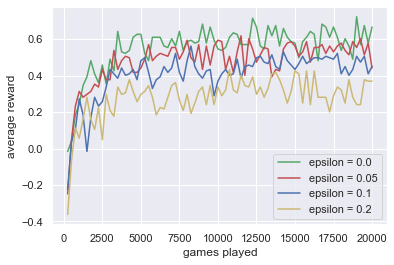

In [394]:
Q0, R0 = qLearning_against_Opt(env, num_episodes = 20000, epsilon = 0.0)
Q1, R1 = qLearning_against_Opt(env, num_episodes = 20000, epsilon = 0.05)
Q2, R2 = qLearning_against_Opt(env, num_episodes = 20000, epsilon = 0.1)
Q3, R3 = qLearning_against_Opt(env, num_episodes = 20000, epsilon = 0.2)

Rplot = np.array([R0, R1, R2, R3])
print(np.shape(Rplot))

display.clear_output(wait = True)
plt.plot(Rplot[0,:,0], Rplot[0,:,1], color='g')
plt.plot(Rplot[1,:,0], Rplot[1,:,1], color='r')
plt.plot(Rplot[2,:,0], Rplot[2,:,1], color='b')
plt.plot(Rplot[3,:,0], Rplot[3,:,1], color='y')
plt.xlabel('games played')
plt.ylabel('average reward')
plt.legend(['epsilon = 0.0','epsilon = 0.05','epsilon = 0.1','epsilon = 0.2'])
plt.savefig('reward.jpg',dpi=300)
plt.show()

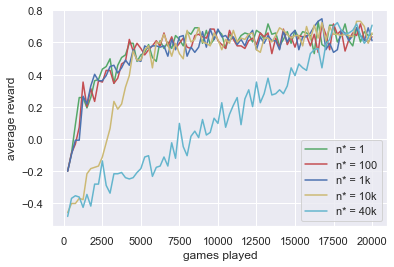

In [8]:
Q0, R0 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 1)
Q1, R1 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 100)
Q2, R2 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 1000)
Q3, R3 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 10000)
Q4, R4 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 40000)

Rplot = np.array([R0, R1, R2, R3,R4])
print(np.shape(Rplot))

display.clear_output(wait = True)
plt.plot(Rplot[0,:,0], Rplot[0,:,1], color='g')
plt.plot(Rplot[1,:,0], Rplot[1,:,1], color='r')
plt.plot(Rplot[2,:,0], Rplot[2,:,1], color='b')
plt.plot(Rplot[3,:,0], Rplot[3,:,1], color='y')
plt.plot(Rplot[4,:,0], Rplot[4,:,1], color='c')
plt.xlabel('games played')
plt.ylabel('average reward')
plt.legend(['n* = 1','n* = 100','n* = 1k','n* = 10k','n* = 40k'])
plt.savefig('reward_epsilon.jpg',dpi=300)
plt.show()

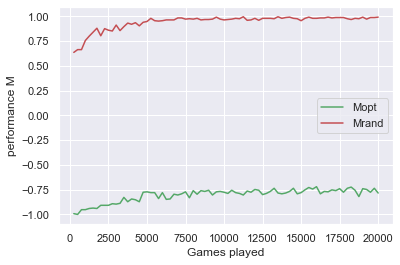

In [396]:
Q0, M0 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 1, Mperf = True)
Q1, M1 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 100, Mperf = True)
Q2, M2 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 1000, Mperf = True)
Q3, M3 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 10000, Mperf = True)
Q4, M4 = qLearning_against_Opt(env, num_episodes = 20000, nmax = 40000, Mperf = True)



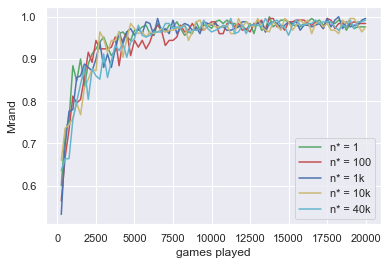

In [397]:
Mplot = np.array([M0, M1, M2, M3, M4])

display.clear_output(wait = True)

plt.plot(Mplot[0,:,0], Mplot[0,:,2], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,2], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,2], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,2], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,2], color='c')

plt.xlabel('games played')
plt.ylabel('Mrand')
plt.legend(['n* = 1','n* = 100','n* = 1k','n* = 10k','n* = 40k'])
plt.savefig('Mrand.jpg',dpi=300)
plt.show()

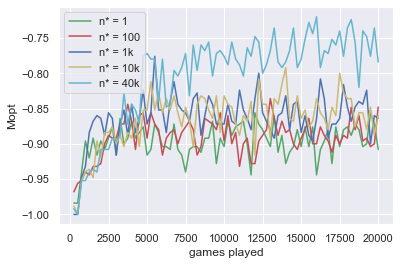

In [398]:
Mplot = np.array([M0, M1, M2, M3, M4])

display.clear_output(wait = True)

plt.plot(Mplot[0,:,0], Mplot[0,:,1], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,1], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,1], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,1], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,1], color='c')

plt.xlabel('games played')
plt.ylabel('Mopt')
plt.legend(['n* = 1','n* = 100','n* = 1k','n* = 10k','n* = 40k'])
plt.savefig('Mopt.jpg',dpi=300)
plt.show()

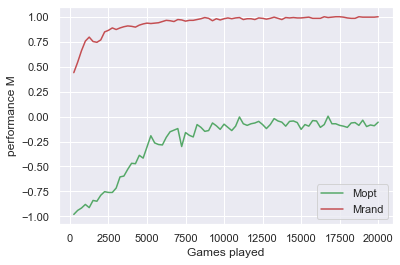

In [399]:
Q0, M0 = qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,
                      opt = 0.0, nmax = 40000, Mperf = True)
Q1, M1 = qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,
                      opt = 0.01, nmax = 40000, Mperf = True)
Q2, M2 = qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,
                      opt = 0.05, nmax = 40000, Mperf = True)
Q3, M3 = qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,
                      opt = 0.1, nmax = 40000, Mperf = True)
Q4, M4 = qLearning_against_Opt(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,
                      opt = 0.2, nmax = 40000, Mperf = True)


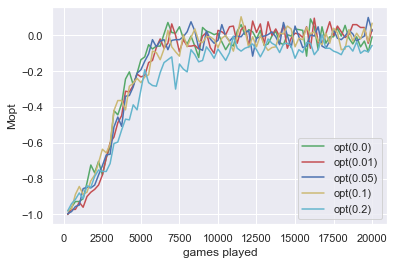

In [402]:
Mplot = np.array([M0, M1, M2, M3, M4])

display.clear_output(wait = True)

plt.plot(Mplot[0,:,0], Mplot[0,:,1], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,1], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,1], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,1], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,1], color='c')

plt.xlabel('games played')
plt.ylabel('Mopt')
plt.legend(['opt(0.0)','opt(0.01)','opt(0.05)','opt(0.1)','opt(0.2)'])
plt.savefig('Mopt_opt.jpg',dpi=300)
plt.show()

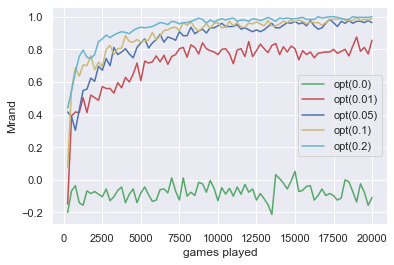

In [403]:
Mplot = np.array([M0, M1, M2, M3, M4])

display.clear_output(wait = True)


plt.plot(Mplot[0,:,0], Mplot[0,:,2], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,2], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,2], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,2], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,2], color='c')

plt.xlabel('games played')
plt.ylabel('Mrand')
plt.legend(['opt(0.0)','opt(0.01)','opt(0.05)','opt(0.1)','opt(0.2)'])
plt.savefig('Mrand_opt.jpg',dpi=300)
plt.show()

In [259]:
def qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, 
                          epsilon = 0.1, opt = 0.5, nmax = None, Mperf = False):
    
    Q = np.zeros((8,8,8,3,8))
    plot = plotAvg()
    mplot = plotM()

    Turns = np.array([0,1])
    epsilon_min = 0.1
    epsilon_max = 0.8
    
    
    for ith_episode in range(num_episodes):

        if not (nmax == None):
            epsilon = max(epsilon_min, epsilon_max*(1-2*ith_episode/nmax))

        state = env.reset()
        #old_state = np.copy(state)
        
        old_state = np.copy(state)
        
        end = False
        
        # play first actions
        own_old_state = np.copy(state)
        action1 = epsilonPolicy(Q, state, epsilon)  
        state,end,_ = env.step(action1) #now agent 2
        own_old_action = action1
        
        old_state = np.copy(state)
        action2 = epsilonPolicy(Q, state, epsilon)  
        state,end,_ = env.step(action2) #now agent 1 again
        actionOponent = action2
        

        while (end == False):
            
            Q = qUpdate(Q, own_old_state, state, own_old_action, env.current_player, discount_factor, alpha)
            
            own_old_state = np.copy(old_state) # save our own old state
            old_state = np.copy(state) # save the state oponent gave us
            
            action = epsilonPolicy(Q, state, epsilon) #chose next action
            state, end, winner = env.step(action) # calculate next state in which we land
            
            
            own_old_action = actionOponent #in the eye of next agent
            actionOponent = action # last action of oponent
            
                
        
        Q = qUpdate(Q, own_old_state, state, own_old_action, env.current_player, discount_factor, alpha)
        Q = qUpdate(Q, old_state, state, action, winner, discount_factor, alpha)
       
        
        
        if (ith_episode%250 == 249):
            if (Mperf == False): plot.plot()
            else:
                mplot.Mopt = performance(Q, num_games = 500, epsilonOpt = 0.0)
                mplot.Mrand = performance(Q, num_games = 500, epsilonOpt = 1.0)
                mplot.plot()
    
    if (Mperf == False): 
        plot.save()
        data = plot.R
    else: 
        mplot.save()
        data = mplot.Mlist

    return Q, data

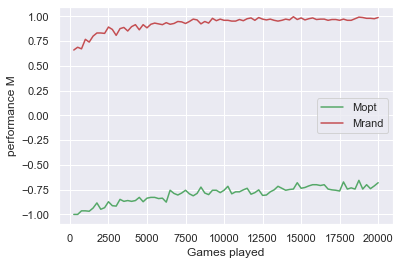

In [342]:
Q0, M0 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.0,
                                      Mperf = True)
Q1, M1 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.1,
                                      Mperf = True)
Q2, M2 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.2,
                                      Mperf = True)
Q3, M3 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.4,
                                      Mperf = True)
Q4, M4 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.8,
                                      Mperf = True)
Q5, M5 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, epsilon = 0.9,
                                      Mperf = True)

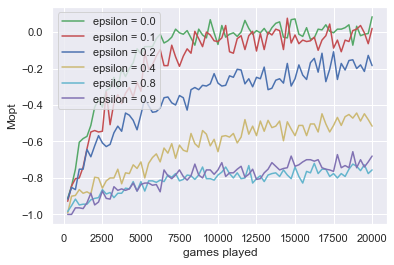

In [346]:
Mplot = np.array([M0, M1, M2, M3, M4, M5])

display.clear_output(wait = True)

plt.plot(Mplot[0,:,0], Mplot[0,:,1], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,1], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,1], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,1], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,1], color='c')
plt.plot(Mplot[5,:,0], Mplot[5,:,1], color='m')


plt.xlabel('games played')
plt.ylabel('Mopt')
plt.legend(['epsilon = 0.0','epsilon = 0.1','epsilon = 0.2','epsilon = 0.4','epsilon = 0.8','epsilon = 0.9'])
plt.savefig('Mopt_itself.jpg',dpi=300)
plt.show()

In [ ]:
Mplot = np.array([M0, M1, M2, M3, M4, M5])

display.clear_output(wait = True)


plt.plot(Mplot[0,:,0], Mplot[0,:,2], color='g')
plt.plot(Mplot[1,:,0], Mplot[1,:,2], color='r')
plt.plot(Mplot[2,:,0], Mplot[2,:,2], color='b')
plt.plot(Mplot[3,:,0], Mplot[3,:,2], color='y')
plt.plot(Mplot[4,:,0], Mplot[4,:,2], color='c')
plt.plot(Mplot[5,:,0], Mplot[5,:,2], color='m')

plt.xlabel('games played')
plt.ylabel('Mopt')
plt.legend(['epsilon = 0.0','epsilon = 0.1','epsilon = 0.2','epsilon = 0.4','epsilon = 0.8','epsilon = 0.9'])
plt.savefig('Mrand_itself.jpg',dpi=300)
plt.show()

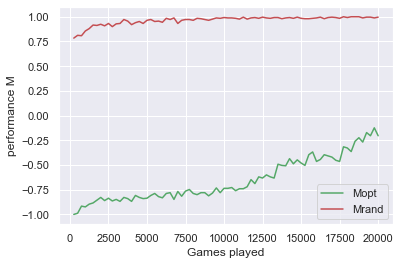

In [347]:
Q0, M0 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, nmax = 1,
                                      Mperf = True)
Q1, M1 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, nmax = 100,
                                      Mperf = True)
Q2, M2 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, nmax = 1000,
                                      Mperf = True)
Q3, M3 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, nmax = 10000,
                                      Mperf = True)
Q4, M4 = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1, nmax = 40000,
                                      Mperf = True)

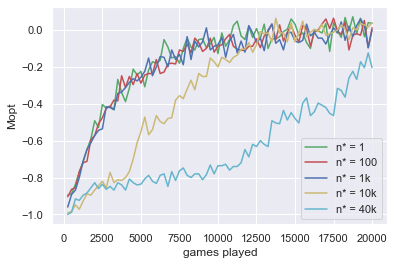

In [351]:
Mplot = np.array([M0, M1, M2, M3, M4])

display.clear_output(wait = True)

plt.plot(Mplot[0,:,0], Mplot[0,:,1], color='g')
#plt.plot(Mplot[0,:,0], Mplot[0,:,2], color='g')

plt.plot(Mplot[1,:,0], Mplot[1,:,1], color='r')
#plt.plot(Mplot[1,:,0], Mplot[1,:,2], color='r')

plt.plot(Mplot[2,:,0], Mplot[2,:,1], color='b')
#plt.plot(Mplot[2,:,0], Mplot[2,:,2], color='b')

plt.plot(Mplot[3,:,0], Mplot[3,:,1], color='y')
#plt.plot(Mplot[3,:,0], Mplot[3,:,2], color='y')

plt.plot(Mplot[4,:,0], Mplot[4,:,1], color='c')
#plt.plot(Mplot[4,:,0], Mplot[4,:,2], color='c')

plt.xlabel('games played')
plt.ylabel('Mopt')
plt.legend(['n* = 1','n* = 100','n* = 1k','n* = 10k','n* = 40k'])
plt.savefig('Mopt_itself_nmax.jpg',dpi=300)
plt.show()

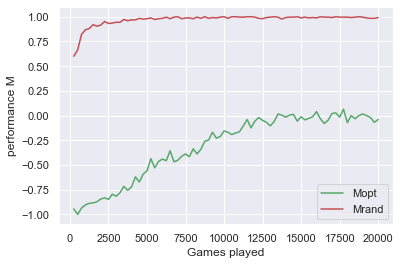

In [391]:
Q, M = qLearning_against_itself(env, num_episodes = 20000, discount_factor = 0.99, alpha = 0.1,nmax= 10000,
                                      Mperf = True)

<ipython-input-404-7680405f952e>:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im)


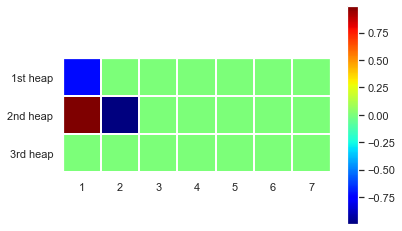

In [404]:
Qplot = Q[1,2,0,:,:]
quantity = [1, 2, 3, 4, 5, 6, 7]
heap = ["1st heap", "2nd heap", "3rd heap"]
fig, ax = plt.subplots()
im = ax.imshow(Qplot, cmap='jet')
ax.set_yticks([0, 1, 2], labels = heap, minor = False)
ax.set_yticks([0.5, 1.5, 2.5], minor=True)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6], labels = quantity, minor = False)
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], minor=True)

ax.yaxis.grid(False, which='major')
ax.yaxis.grid(True, which='minor',linewidth=2)

ax.xaxis.grid(False, which='major')
ax.xaxis.grid(True, which='minor',linewidth=2)

ax.set_xlim(-0.5,6.5)

plt.colorbar(im)

plt.savefig('heatmap.jpg')